In [1]:
# If using Google Colab...
# Mount my Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Natural Lanaguage Processing (NLP) Project

## Data Description
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

# 1. Data Summary

In [3]:
# Import necessary libraries

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import wordcloud                                        # Import wordcloud to create word clouds
from wordcloud import WordCloud
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import pandas as pd                                     # Import Pandas for data
import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from sklearn.ensemble import RandomForestClassifier     # Import Random Forest classifier
from sklearn.model_selection import train_test_split    # Import Train Test Split for modeling fitting
from sklearn.model_selection import cross_val_score     # Import cross validation score
from sklearn.model_selection import RandomizedSearchCV  # Import RandomizedSearchCV for hyperparameter tuning
from sklearn.datasets import load_digits    

from collections import Counter                         # Import Counter to count word frequency

from scipy.stats import randint as sp_randint

from sklearn import metrics                             # Import metrics for evaluating the model
from sklearn.metrics import confusion_matrix            # Import confusion matrix for evaluating the model

import matplotlib.pyplot as plt                         # Import plt for visualization
import seaborn as sns                                   # Import seaborn for visualization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# Load the data

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/Tweets.csv')

In [5]:
# Check the shape of the data

df.shape

(14640, 15)

#### Observations
There are 14,640 rows of data and 15 columns

In [6]:
# Check the first 5 rows of data

df.head()

tweet_id  ...               user_timezone
0  570306133677760513  ...  Eastern Time (US & Canada)
1  570301130888122368  ...  Pacific Time (US & Canada)
2  570301083672813571  ...  Central Time (US & Canada)
3  570301031407624196  ...  Pacific Time (US & Canada)
4  570300817074462722  ...  Pacific Time (US & Canada)

[5 rows x 15 columns]

In [7]:
# Show the column names

df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

#### Observations
Each row is an individual tweet as well as other information about the tweet, especially around the tweet's sentiment

Columns include:
    - **Index** which is the index column of the dataset
    - **tweet_id** which is the ID # of the tweet
    - **airline_sentiment** which is a classification of whether the tweet was positive, negative, or neutral about the airline
    - **airline_sentiment_confidence** which is a measure of how likely the sentiment classification is accurate
    - **negativereason** which is a subjective comment on why the user had negative sentiment about the airline
    - **negativereason_confidence** which is a measure of how likely the negative reason is accurate
    - **airline** which is the airline the tweet was made about
    - **airline_sentiment_gold** which is unclear what it is
    - **name** which is the username of the user who tweeted
    - **negativereason_gold** which I'm not sure what it is
    - **retweet_count** which is the number of times the tweet was retweeted by other users
    - **text** which is the text of the tweet
    - **tweet_coord** which I'm not sure what it is
    - **tweet_created** which is the date the tweet was made
    - **tweet_location** which I'm not sure what it is
    - **user_timezone** which is the timezone of the person who made the tweet

In [8]:
# Show the description of the data

df.describe()

tweet_id  ...  retweet_count
count  1.464000e+04  ...   14640.000000
mean   5.692184e+17  ...       0.082650
std    7.791112e+14  ...       0.745778
min    5.675883e+17  ...       0.000000
25%    5.685592e+17  ...       0.000000
50%    5.694779e+17  ...       0.000000
75%    5.698905e+17  ...       0.000000
max    5.703106e+17  ...      44.000000

[8 rows x 4 columns]

#### Observations
- Most of the tweets didn't have any retweets at all. The most was 44 retweets. 
- Average confidence about the sentiment is pretty high (around 90%)
- Average confidence about the negative reason is lower, only around 63% 

In [9]:
# Check how many null values there are in each column

df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [10]:
# Show the percentage of values in each column which are null

(df.isna().sum() * 100 / df.index.size).round(2)

tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

#### Observations
- We have a sentiment and corresponding confidence for each tweet
- We are missing a negative reason from 37% of the tweets
- airline_sentiment_gold, negativereason_gold, and tweet_cord are mostly null (99%, 99% and 93% null respectively). I will drop these columns because they add little value
- Tweet location and user timezone have 32% null values

# 2. Exploratory Data Analysis (EDA)

In [11]:
# Count the number of each sentiment

df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

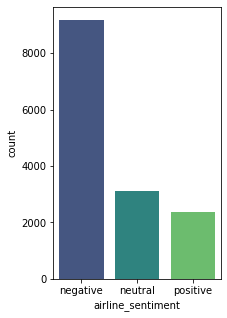

In [12]:
# Visualize the distribution of sentiment across all tweets

plt.figure(figsize=(3,5))
sns.countplot(
    x = 'airline_sentiment', 
    data = df, 
    order = df.airline_sentiment.value_counts().index,
    palette = 'viridis')

plt.show()

#### Observations
- The vast majority (over 9,000) of these tweets has a negative sentiment about the airline.
- Positive sentiment is the least common type, with less than 2,400 tweets.

## Distribution of Tweets by Airline

In [13]:
# Count the distribution of all tweets among each airline

df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [14]:
# Plot the distribution of all tweets among each airline

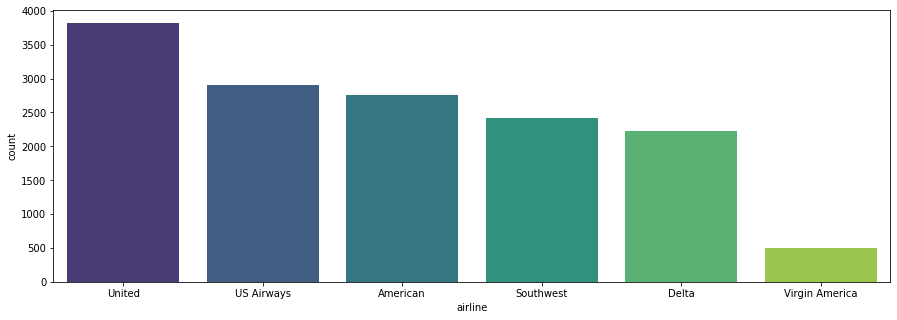

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(
    x = 'airline', 
    data = df, 
    order = df.airline.value_counts().index, 
    palette = 'viridis')

plt.show()

#### Observations
- The airline with the most tweets about it is United with over 3,800 tweets
- The airline with the fewest tweets about it is Virgin America with just over 504 tweets
- The other airlines are fairly close with between 2222 and 2913 tweets each

## Distribution of Tweet Sentiment by Airline

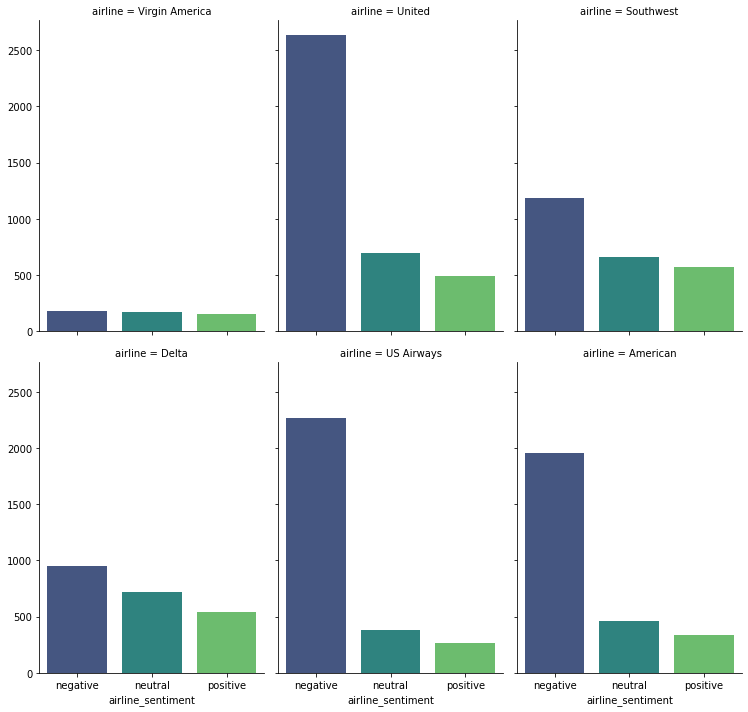

In [16]:
# Plot the distribution of Sentiment of tweets for each airline

g = sns.FacetGrid(
    data = df, 
    col = 'airline', 
    col_wrap = 3, 
    height = 5, 
    aspect = 0.7
) 

g = g.map(
    sns.countplot, 
    'airline_sentiment',
    order = df.airline_sentiment.value_counts().index,
    palette = 'viridis'
) 

plt.show()

#### Observations
- The distribution of sentiment across each airline is generally similar to the distribution across all tweets. The exceptions being Delta, Virgin America, and Soutwest, which have a somewhat more even distribution (not as heavily skewed towards negative as the other airlines)
- Virgin America has the most even distribution of sentiment, but also the fewest tweets

## Distribution of All Negative Reasons

In [17]:
# Count the distribution of all negative reasons

df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

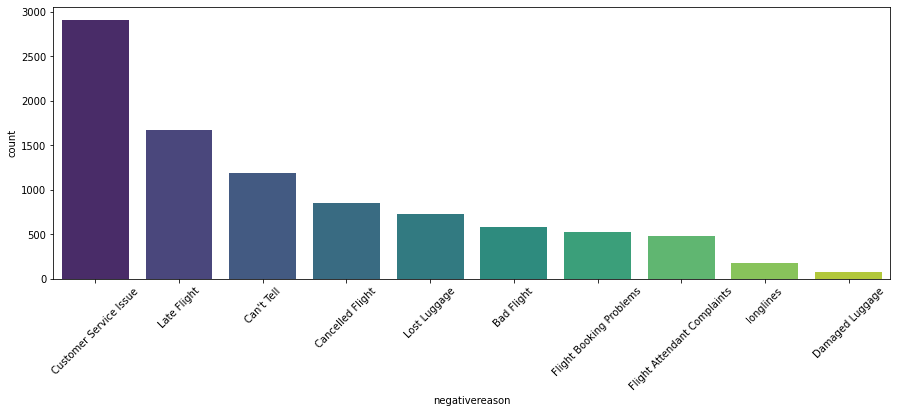

In [18]:
# Plot the distribution of all the negative reasons

plt.figure(figsize=(15,5))
sns.countplot(
    x = 'negativereason', 
    data = df, 
    order = df.negativereason.value_counts().index, 
    palette = 'viridis')

plt.xticks(rotation=45)

plt.show()

#### Observations
- The most common negative sentiment reason is a customer service issue
- The least common is damaged luggage. 
- The data set includes 10 unique negative sentiment reasons, including one for called "Can't Tell" where the person categorizing couldn't determine the reason

## Word Cloud Graphs of Tweets

In [19]:
# Plot the word cloud graph of tweets for positive and negative sentiment separately.

In [20]:
# Define a function to create a word cloud of the tweet text

df_copy = df.copy()

df_copy['text'] = df_copy.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

def show_wordcloud(df_copy, title):
    text = ' '.join(df_copy['text'].astype(str).tolist())                 # Converting Summary column into list
    stopwords = set(wordcloud.STOPWORDS)                                  # instantiate the stopwords from wordcloud
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',          # Setting the different parameter of stopwords
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)                             
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

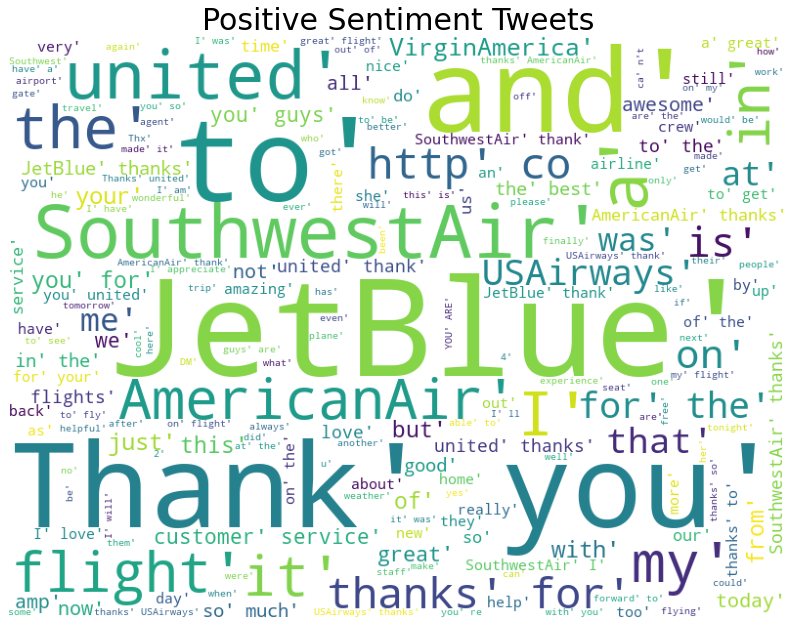

In [21]:
# Plot a word cloud of text for positive tweets

show_wordcloud(df_copy[df_copy['airline_sentiment'] == 'positive'], title = "Positive Sentiment Tweets")

#### Observations
- Oddly, JetBlue is a very common word in positive tweets even though JetBlue is not one of the airlines included in this dataset. So either some tweets are miscategorized or people are comparing their positive experiences to JetBlue (which is known for good customer experiences)
- Thank You is a common phrase in the positive tweets
- Southwest also seems to get a lot of mentions in positive tweets

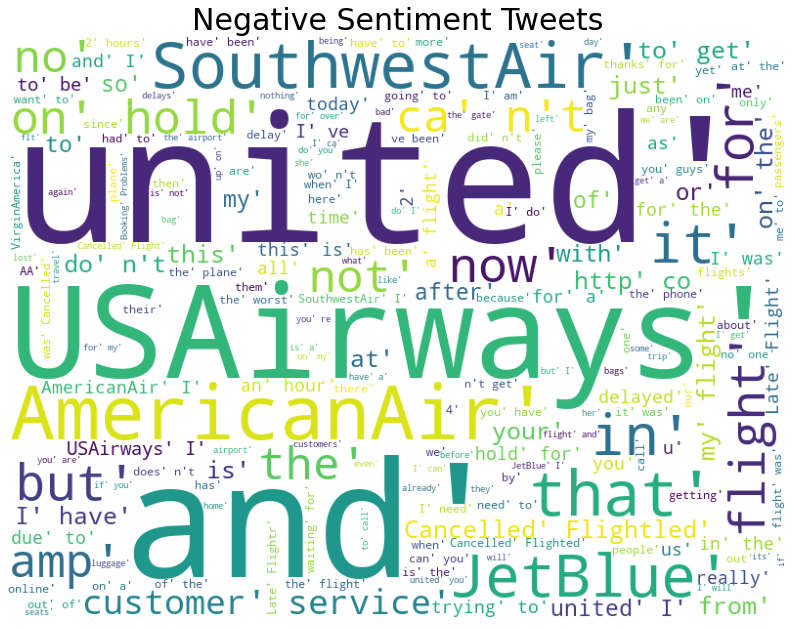

In [22]:
# Plot a word cloud of text for negative tweets

show_wordcloud(df_copy[df_copy['airline_sentiment'] == 'negative'], title = "Negative Sentiment Tweets")

#### Observations
- "And" seemes to be the most common word in negative tweets, for some reason
- AmericanAir, United, and US Airways are frequently mentioned in these negative tweets
- Some other commonly used words that stand out are "on hold", "Cancelled flight", "Can't", and "customer service" 

# 3. Understanding of Data Columns

In [23]:
# Drop all other columns except “text” and “airline_sentiment”

df.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis=1, inplace=True)

In [24]:
# Check the shape of the data now that we've dropped unnecessary columns

df.shape

(14640, 2)

In [25]:
# Print the first 5 rows of data

df.head()

airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...

In [26]:
# Display full dataframe information so full Tweet text displays
pd.set_option('display.max_colwidth', None)

# Check the first 5 rows of data
df.head()

airline_sentiment                                                                                                                            text
0           neutral                                                                                             @VirginAmerica What @dhepburn said.
1          positive                                                        @VirginAmerica plus you've added commercials to the experience... tacky.
2           neutral                                                         @VirginAmerica I didn't today... Must mean I need to take another trip!
3          negative  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4          negative                                                                         @VirginAmerica and it's a really big bad thing about it

#### Observations
- I successfully dropped all columns except airline_sentiment and text
- The dataframe is now ready for data pre-processing and model building.
- Full tweet text is now visible so I'll be able to see effects of pre-processing steps

# 4. Data Pre-Processing

## Noise Removal

### Remove HTML Tags

In [27]:
# Define a function to strip html tags from the text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

# Apply the function to strip html tags from the text
df['text'] = df['text'].apply(lambda x: strip_html(x))

# Check the first 10 rows to see how the data has changed
df.head(10)

airline_sentiment                                                                                                                                      text
0           neutral                                                                                                       @VirginAmerica What @dhepburn said.
1          positive                                                                  @VirginAmerica plus you've added commercials to the experience... tacky.
2           neutral                                                                   @VirginAmerica I didn't today... Must mean I need to take another trip!
3          negative                @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4          negative                                                                                   @VirginAmerica and it's a really big bad thing about it
5          negative  @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6          positive                                                           @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7           neutral                              @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
8          positive                                                                                           @virginamerica Well, I didn't…but NOW I DO! :-D
9          positive                                                          @VirginAmerica it was amazing, and arrived an hour early. You're too good to me.

#### Observations
- The "amp;" was removed from the 4th tweet, so it appears to have worked.
- HTML tags have been removed from the tweet text

### Remove URLs

In [28]:
# Define function to remove http links using Regular Expression.
for i, row in df.iterrows():
    clean_tweet = re.sub(r"http\S+", "", df.at[i, 'text'])
    df.at[i,'text'] = clean_tweet

# Check the first 10 rows to see if it removed URLs
df.head(10)

airline_sentiment                                                                                                                                      text
0           neutral                                                                                                       @VirginAmerica What @dhepburn said.
1          positive                                                                  @VirginAmerica plus you've added commercials to the experience... tacky.
2           neutral                                                                   @VirginAmerica I didn't today... Must mean I need to take another trip!
3          negative                @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4          negative                                                                                   @VirginAmerica and it's a really big bad thing about it
5          negative  @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6          positive                                                           @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7           neutral                                                     @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. 
8          positive                                                                                           @virginamerica Well, I didn't…but NOW I DO! :-D
9          positive                                                          @VirginAmerica it was amazing, and arrived an hour early. You're too good to me.

#### Observations
- There was a URL at the end of the 8th tweet. The URL is now gone
- Successfully removed URLs from the text of each tweet

### Replace Contractions

In [29]:
# Define a function to replay contractions in the text with their two word forms
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Apply the function to remove contractions from the tweet text
df['text'] = df['text'].apply(lambda x: replace_contractions(x))

# Check the first 5 rows to see how the data has changed
df.head()

airline_sentiment                                                                                                                         text
0           neutral                                                                                          @VirginAmerica What @dhepburn said.
1          positive                                                   @VirginAmerica plus you have added commercials to the experience... tacky.
2           neutral                                                     @VirginAmerica I did not today... Must mean I need to take another trip!
3          negative  @VirginAmerica it is really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4          negative                                                                     @VirginAmerica and it is a really big bad thing about it

#### Observations
- In the 3rd tweet, "didn't" has been replaced with "did not"
- In the 4th tweet, "it's" has been replaced with "it is" 
- All contractions have been converted to their two word forms

### Remove Numbers

In [30]:
# Show first 25 tweets to find some with numbers in them
df.head(25)

airline_sentiment                                                                                                                                            text
0            neutral                                                                                                             @VirginAmerica What @dhepburn said.
1           positive                                                                      @VirginAmerica plus you have added commercials to the experience... tacky.
2            neutral                                                                        @VirginAmerica I did not today... Must mean I need to take another trip!
3           negative                     @VirginAmerica it is really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4           negative                                                                                        @VirginAmerica and it is a really big bad thing about it
5           negative      @VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6           positive                                                              @VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)
7            neutral                                                           @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. 
8           positive                                                                                                @virginamerica Well, I did not…but NOW I DO! :-D
9           positive                                                               @VirginAmerica it was amazing, and arrived an hour early. you are too good to me.
10           neutral                                               @VirginAmerica did you know that suicide is the second leading because of death among teens 10-24
11          positive                                                                @VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D
12          positive        @VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia & I have not even gone on my 1st trip yet! ;p
13          positive                       @VirginAmerica @virginmedia I am flying your #fabulous #Seductive skies again! you take all the #stress away from travel 
14          positive                                                                                                                          @VirginAmerica Thanks!
15          negative                                                                                                   @VirginAmerica SFO-PDX schedule is still MIA.
16          positive  @VirginAmerica So excited for my first cross country flight LAX to MCO I have heard nothing but great things about Virgin America. #29DaysToGo
17          negative      @VirginAmerica  I flew from NYC to SFO last week and could not fully sit in my seat due to two large gentleman on either side of me. HELP!
18          positive                                                                                                                 I ❤️ flying @VirginAmerica. ☺️👍
19          positive                                     @VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.
20          negative              @VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
21          positive                                                                                                            @VirginAmerica I love this graphic. 
22          positive                                                                        @VirginAmerica I love the hipster innovation. You are a feel good brand.
23           neutral                       

In [31]:
# Define a function to remove numbers from the text of each tweet
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# Apply the function to remove numbers from the tweet text
df['text'] = df['text'].apply(lambda x: remove_numbers(x))

# Check the first 25 rows to see how the data has changed
df.head(25)

airline_sentiment                                                                                                                                          text
0            neutral                                                                                                           @VirginAmerica What @dhepburn said.
1           positive                                                                    @VirginAmerica plus you have added commercials to the experience... tacky.
2            neutral                                                                      @VirginAmerica I did not today... Must mean I need to take another trip!
3           negative                   @VirginAmerica it is really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4           negative                                                                                      @VirginAmerica and it is a really big bad thing about it
5           negative      @VirginAmerica seriously would pay $ a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6           positive                                                            @VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)
7            neutral                                                         @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. 
8           positive                                                                                              @virginamerica Well, I did not…but NOW I DO! :-D
9           positive                                                             @VirginAmerica it was amazing, and arrived an hour early. you are too good to me.
10           neutral                                                 @VirginAmerica did you know that suicide is the second leading because of death among teens -
11          positive                                                               @VirginAmerica I < pretty graphics. so much better than minimal iconography. :D
12          positive        @VirginAmerica This is such a great deal! Already thinking about my nd trip to @Australia & I have not even gone on my st trip yet! ;p
13          positive                     @VirginAmerica @virginmedia I am flying your #fabulous #Seductive skies again! you take all the #stress away from travel 
14          positive                                                                                                                        @VirginAmerica Thanks!
15          negative                                                                                                 @VirginAmerica SFO-PDX schedule is still MIA.
16          positive  @VirginAmerica So excited for my first cross country flight LAX to MCO I have heard nothing but great things about Virgin America. #DaysToGo
17          negative    @VirginAmerica  I flew from NYC to SFO last week and could not fully sit in my seat due to two large gentleman on either side of me. HELP!
18          positive                                                                                                               I ❤️ flying @VirginAmerica. ☺️👍
19          positive                                   @VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.
20          negative            @VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
21          positive                                                                                                          @VirginAmerica I love this graphic. 
22          positive                                                                      @VirginAmerica I love the hipster innovation. You are a feel good brand.
23           neutral                                                                  @Virg

#### Observations
- The numbers 10 and 24 were removed from the 11th tweet 
- The number 2 was removed from the 13th tweet. 

## Tokenization

In [32]:
# Apply a lambda function with nltk's word_tokenize to tokenize the tweet text
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

# Check the first 5 rows to see how the data has changed
df.head()

airline_sentiment                                                                                                                                                      text
0           neutral                                                                                                            [@, VirginAmerica, What, @, dhepburn, said, .]
1          positive                                                               [@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]
2           neutral                                                              [@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]
3          negative  [@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]
4          negative                                                                                    [@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]

#### Observations
- Each tweet has now been converted to a list of words separated by columns

## Normalization

### Remove Special Characters

In [33]:
# Define a function to remove non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# Apply the function to remove non-ASCII characters from the tweet text
df['text'] = df['text'].apply(lambda x: remove_non_ascii(x))

# Check the first 25 rows to see how the data has changed
df.head(25)

airline_sentiment                                                                                                                                                                          text
0            neutral                                                                                                                                [@, VirginAmerica, What, @, dhepburn, said, .]
1           positive                                                                                   [@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]
2            neutral                                                                                  [@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]
3           negative                      [@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]
4           negative                                                                                                        [@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]
5           negative         [@, VirginAmerica, seriously, would, pay, $, a, flight, for, seats, that, did, not, have, this, playing, ., it, is, really, the, only, bad, thing, about, flying, VA]
6           positive                                                                   [@, VirginAmerica, yes, ,, nearly, every, time, I, fly, VX, this, , ear, worm, , will, not, go, away, :, )]
7            neutral                                                                       [@, VirginAmerica, Really, missed, a, prime, opportunity, for, Men, Without, Hats, parody, ,, there, .]
8           positive                                                                                                          [@, virginamerica, Well, ,, I, did, not...but, NOW, I, DO, !, :, -D]
9           positive                                                                     [@, VirginAmerica, it, was, amazing, ,, and, arrived, an, hour, early, ., you, are, too, good, to, me, .]
10           neutral                                                              [@, VirginAmerica, did, you, know, that, suicide, is, the, second, leading, because, of, death, among, teens, -]
11          positive                                                                          [@, VirginAmerica, I, <, pretty, graphics, ., so, much, better, than, minimal, iconography, ., :, D]
12          positive  [@, VirginAmerica, This, is, such, a, great, deal, !, Already, thinking, about, my, nd, trip, to, @, Australia, &, I, have, not, even, gone, on, my, st, trip, yet, !, ;, p]
13          positive                       [@, VirginAmerica, @, virginmedia, I, am, flying, your, #, fabulous, #, Seductive, skies, again, !, you, take, all, the, #, stress, away, from, travel]
14          positive                                                                                                                                                 [@, VirginAmerica, Thanks, !]
15          negative                                                                                                                      [@, VirginAmerica, SFO-PDX, schedule, is, still, MIA, .]
16          positive    [@, VirginAmerica, So, excited, for, my, first, cross, country, flight, LAX, to, MCO, I, have, heard, nothing, but, great, things, about, Virgin, America, ., #, DaysToGo]
17          negative  [@, VirginAmerica, I, flew, from, NYC, to, SFO, last, week, and, could, not, fully, sit, in, my, seat, due, to, two, large, gentleman, on, either, side, of, me, ., HELP, !]
18          positive                                                                                                                                          [I, , flying, @, VirginAmerica, ., ]
19          positive                             [@, VirginAmerica, you, know, what, would, be, amazing

#### Observations
- The emojis have been removed from the 19th and 25th tweets, so it worked

### Remove Punctuation

In [34]:
# Define a function to remove punctuation from the text
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Apply the function to remove punctuation from the tweet text
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))

# Check the first 5 rows to see how the data has changed
df.head()

airline_sentiment                                                                                                                                     text
0           neutral                                                                                                    [VirginAmerica, What, dhepburn, said]
1          positive                                                         [VirginAmerica, plus, you, have, added, commercials, to, the, experience, tacky]
2           neutral                                                        [VirginAmerica, I, did, not, today, Must, mean, I, need, to, take, another, trip]
3          negative  [VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]
4          negative                                                                      [VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]

#### Observations
- "@" has been removed from every row
- Other punctuation marks have been removed, too

### Remove Stop Words

In [35]:
# Define variable to use English stopwords and keep the word "not" bc it's important for sentiment analysis
stopwords = stopwords.words('english')
stopwords.remove('not')

# Define a function to remove stop words from the text
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words

# Apply the function to remove stop words from the tweet text
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

# Check the first 5 rows to see how the data has changed
df.head()

airline_sentiment                                                                                                   text
0           neutral                                                                  [VirginAmerica, What, dhepburn, said]
1          positive                                           [VirginAmerica, plus, added, commercials, experience, tacky]
2           neutral                               [VirginAmerica, I, not, today, Must, mean, I, need, take, another, trip]
3          negative  [VirginAmerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]
4          negative                                                               [VirginAmerica, really, big, bad, thing]

#### Observations
- "You", "have", "to", and "the" were removed from the second tweet
- "Not" was kept in the text, as intended, in the third tweet
- Stopwords have been removed from the tweets

### Convert to Lowercase

In [36]:
# Define a function to convert all words to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Apply the function to remove non-ASCII characters from the tweet text
df['text'] = df['text'].apply(lambda x: to_lowercase(x))

# Check the first 5 rows to see how the data has changed
df.head()

airline_sentiment                                                                                                   text
0           neutral                                                                  [virginamerica, what, dhepburn, said]
1          positive                                           [virginamerica, plus, added, commercials, experience, tacky]
2           neutral                               [virginamerica, i, not, today, must, mean, i, need, take, another, trip]
3          negative  [virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]
4          negative                                                               [virginamerica, really, big, bad, thing]

#### Observations
- In each of the first 5 tweets, VirginAmerica has been converted to lowercase
- All words are now lowercase

### Lemmatization

In [37]:
# Define a function to lemmatize the words in the tweets
def lemmatize_list(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas

# Apply the function to lemmatize the words in each tweet
df['text'] = df['text'].apply(lambda x: lemmatize_list(x))

# Check the first 5 rows to see how the data has changed
df.head()

airline_sentiment                                                                                                 text
0           neutral                                                                [virginamerica, what, dhepburn, said]
1          positive                                          [virginamerica, plus, added, commercial, experience, tacky]
2           neutral                             [virginamerica, i, not, today, must, mean, i, need, take, another, trip]
3          negative  [virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, little, recourse]
4          negative                                                             [virginamerica, really, big, bad, thing]

#### Observations
- In the 2nd tweet, "commercials" is converted to "commercial"
- In the 4th tweet, "guests" is converted to "guest"
- Lemmatization was successful and words have been mapped to their root form

## Convert Back to Text String

Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.

In [38]:
# Aggregate the preprocessing functions into one
def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = to_lowercase(words)
    words = lemmatize_list(words)
    return ' '.join(words)

# Apply the aggregated function and join the words in the list to convert back to text string in df
df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)

# Check the first 5 rows
df.head()

airline_sentiment                                                                                      text
0           neutral                                                               virginamerica dhepburn said
1          positive                                      virginamerica plus added commercial experience tacky
2           neutral                                  virginamerica not today must mean need take another trip
3          negative  virginamerica really aggressive blast obnoxious entertainment guest face little recourse
4          negative                                                        virginamerica really big bad thing

#### Observations
- Successfully pre-processed the tweets' text
- Text has been converted back into a text string in each row

# 5. Vectorization

#### Observation
First, I want to see how common each word is so I'll know what limits to try for the max_features hyperparameter

In [39]:
# Create a copy of the dataframe
df_copy = df.copy()

# Tokenize the text column in the df copy so we can count word frequency
df_copy['text'] = df_copy.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

# Define a variable using the Counter() function
top = Counter([item for sublist in df_copy['text'] for item in sublist])

In [40]:
# Show the frequency of the words in the text column
freq = pd.DataFrame(top.most_common())
freq.columns = ['Common_words','count']
freq.style.background_gradient(cmap='Reds')

#### Observations
- There are a total of 11,645 unique words in the text column
- Around the 1,000th most common word, frequency drops off to fewer than 20. 
- I will start with limiting max_features to the top 1,000 words

## CountVectorizer

In [41]:
# Create CountVectorizer vectorizer
# Keep only 1000 features 
cv = CountVectorizer(max_features=1000) 

# Fit and transform on the text column
cv_features = cv.fit_transform(df['text'])

# Convert the features to an array
cv_features = cv_features.toarray()               

In [42]:
# Check the shape of the new array
cv_features.shape

(14640, 1000)

#### Observations
The new array has 14,640 rows (1 for each tweet) and 11,626 columns (1 for each word)

## TF-IDF Vectorizer

In [43]:
# Create TF-IDF vectorizer 
# Keep only 2000 features
tfidf = TfidfVectorizer(max_features=1000)

# Fit and transform on the text column
tf_features = tfidf.fit_transform(df['text'])

# Convert the features to an array
tf_features = tf_features.toarray()  

In [44]:
# Check the shape of the new array
tf_features.shape

(14640, 1000)

#### Observations
As as the CV array, the TF-IDF array has 14,640 rows (1 for each tweet) and 1,000 columns (1 for each word) because I limited max_features to 1,000. 

# 6. Modeling, Tuning, and Evaluation

Fit the model using vectorized column - Tune the model to improve the accuracy - Evaluate the model using the confusion matrix (on both types of vectorization) - Print the top 40 features and plot their word cloud using both types of vectorization. (7+7 Marks)

It is not mandatory to encode the target column before training the model. You can proceed with modeling without encoding too

You can apply any classification algorithm which has been covered in the course so far

In [45]:
labels = df['airline_sentiment']

## Fit the CountVectorizer Model 

In [46]:
# Split the CountVectorizer data into training and testing set.

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(cv_features, labels, test_size=0.3, random_state=12)

# Check the shape of the split data
print("X_train")
print(X_train_cv.shape)
print("X_test")
print(X_test_cv.shape)
print("y_train")
print(y_train_cv.shape)
print("y_test")
print(X_test_cv.shape)

X_train
(10248, 1000)
X_test
(4392, 1000)
y_train
(10248,)
y_test
(4392, 1000)


#### Observations
Data has been split properly and is ready to be fit

In [47]:
# Using Random Forest to build model for the classification of reviews
rf = RandomForestClassifier(n_jobs=-1)

# Fit to the CountVectorizer data
cv_rf = rf.fit(X_train_cv, y_train_cv)

print(cv_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [48]:
# Calculate the cross validation score on training
print(np.mean(cross_val_score(cv_rf, cv_features, labels, cv=10)))

0.7224726775956285


#### Observations
The default random forest model with CountVectorizer has a mean accuracy score of around 72%

## Tune the CountVectorizer Model

In [49]:
%%time

# Parameters to pass in RandomizedSearchCV
param_dist = {'n_estimators': sp_randint(4,200),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Type of scoring used to compare parameter combinations
#scorer = metrics.make_scorer(metrics.recall_score)

# Random search of parameters, using 10 fold cross validation, 
# Search across 100 different combinations, and use all available cores
cv_rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = param_dist, 
    n_iter = 100, 
    cv = 3, 
    random_state=12)

# Fit the random search model
cv_rf_random.fit(X_train_cv, y_train_cv)

print("Best parameters are {} with CV score={}:" .format(cv_rf_random.best_params_,cv_rf_random.best_score_))

Best parameters are {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 108} with CV score=0.7663934426229507:
CPU times: user 1min 45s, sys: 7.72 s, total: 1min 53s
Wall time: 6min 59s


In [50]:
# Training the tuned model
cv_rf_tuned = RandomForestClassifier(
    bootstrap = False,
    criterion = 'gini',
    max_depth = None, 
    max_features = 7, 
    min_samples_leaf = 1,
    min_samples_split = 7,
    n_estimators = 108,
    n_jobs = -1
    )

# Fit the tuned model
cv_rf_tuned.fit(X_train_cv, y_train_cv)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=108,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

#### Observations
Even with RandomSearchCV, it took about 7 mins to find the optimal parameters. That's longer than our previous projects where we were dealing with numerical data

## Evaluate the CountVectorizer Model

In [51]:
# Saving the prediction on train data as a result
cv_train_result =  cv_rf_tuned.predict(X_train_cv)  

# Saving the prediction on test data as a result
cv_test_result =  cv_rf_tuned.predict(X_test_cv)  

# Calculate the accuracy score
print("Accuracy on training set: ", cv_rf_tuned.score(X_train_cv, y_train_cv))
print("Accuracy on test set: ", cv_rf_tuned.score(X_test_cv, y_test_cv))

#Recall of the model
print("Recall on training set: ", metrics.recall_score(y_train_cv , cv_train_result, average = 'macro'))
print("Recall on test set: ", metrics.recall_score(y_test_cv , cv_test_result, average = 'macro'))

# Calculate the F1 score 
print("F1 score on training set: ", metrics.f1_score(y_train_cv, cv_train_result, average='macro'))
print("F1 score on test set: ", metrics.f1_score(y_test_cv, cv_test_result, average='macro'))

Accuracy on training set:  0.9877049180327869
Accuracy on test set:  0.7780054644808743
Recall on training set:  0.9827662320389144
Recall on test set:  0.6552485912469046
F1 score on training set:  0.9822087221194025
F1 score on test set:  0.6867705377436425


#### Observations
- The model is definitely overfitting -- scores on training are very high and scores on test are not great.
- Accuracy is around 77% which is higher than F1 score around 68%, probably because of the imbalanced dataset (many more negative reviews)

[[2594  143   47]
 [ 401  411   72]
 [ 228   84  412]]



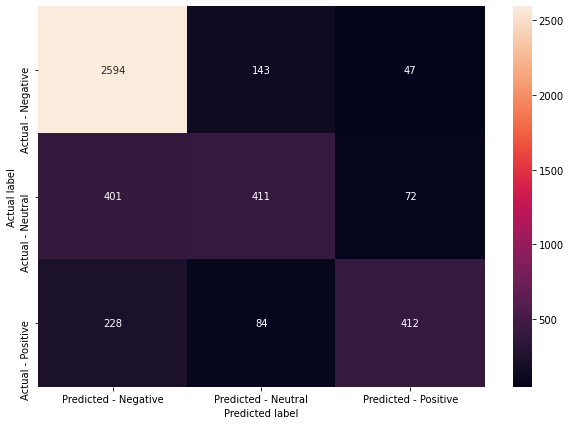

In [52]:
# Print and plot a Confusion matrix

conf_mat = confusion_matrix(y_test_cv, cv_test_result)

print(conf_mat)
print()

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Actual - Negative", "Actual - Neutral", "Actual - Positive"]],
                  columns = [i for i in ["Predicted - Negative", "Predicted - Neutral", "Predicted - Positive"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Observations
- The model struggled with over-predicting tweets as negative, especially confusing negative with what was actually labeled as neutral. 
- Again, the imbalance in the data is evident and likely causing issues. 

## Top 40 Features with CountVectorizer & Random Forest Model

In [53]:
# Show the top 40 features for CountVectorizer & Random Forest Model

all_features = cv.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                    # Addition of top 40 feature into top_feature after training the model
feat=cv_rf_tuned.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '

print("The Top 40 features in this model are:")
top_features

The Top 40 features in this model are:


'thank thanks not hour usairways jetblue great cancelled flight delayed southwestair united customer love bag hold awesome americanair delay virginamerica best time get amazing call service hr plane still day dm good worst fleek never much airline phone min need '

#### Observations
- I would have expected lemmatization to combine "thank" and "thanks" but it did not. They are the two most common words. 
- The twitter handle of each airline are top features. If I was doing more work on this, i would want to try removing those like stopwords to see if it improves the model. 

## Word Cloud with CountVectorizer & Random Forest Model

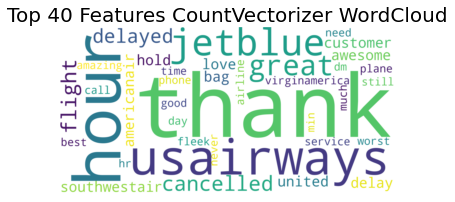

In [54]:
wordcloud_cv = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud_cv, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 Features CountVectorizer WordCloud', fontsize=20)
plt.axis("off")
plt.show()

#### Observations
- In the word cloud, "thank" is obviously the top word, but "thanks" is not shown. 
- Hour is a very prominent word in this model.
- Interesting again that jetblue is a top feature even though it's not one of the airlines included in this data. It must be that many customers are comparing their experience to JetBlue. 

## Fit the TF-IDF Model

In [55]:
# Split the TF-IDF data into training and testing set.

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tf_features, labels, test_size=0.3, random_state=12)

# Check the shape of the split data
print("X_train_tf")
print(X_train_tf.shape)
print("X_test_tf")
print(X_test_tf.shape)
print("y_train_tf")
print(y_train_tf.shape)
print("y_test_tf")
print(X_test_tf.shape)

X_train_tf
(10248, 1000)
X_test_tf
(4392, 1000)
y_train_tf
(10248,)
y_test_tf
(4392, 1000)


#### Observations
Data has been split properly and is ready to be fit

In [56]:
# Using Random Forest to build model for the classification of reviews
rf2 = RandomForestClassifier(n_jobs=-1)

# Fit to the TF-IDF data
tf_rf = rf2.fit(X_train_tf, y_train_tf)

print(tf_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [57]:
# Calculate the cross validation score on training
print(np.mean(cross_val_score(tf_rf, tf_features, labels, cv=10)))

0.7172814207650274


#### Observations
- The TF-IDF data has been fit to a default Random Forest model. 
- I am surprised that the mean cross-validated accuracy score is actually lower. Given that TF-IDF is supposed to help adjust the importance of features based on the frequency they show in all the text, I would have expected that to help and for this model's performance to be higher. 

## Tune the TF-IDF Model

In [58]:
%%time

# Parameters to pass in RandomizedSearchCV
param_dist2 = {'n_estimators': sp_randint(4,200),
              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Type of scoring used to compare parameter combinations
#scorer = metrics.make_scorer(metrics.recall_score)

# Random search of parameters, using 10 fold cross validation, 
# Search across 100 different combinations, and use all available cores
tf_rf_random = RandomizedSearchCV(
    estimator = rf2, 
    param_distributions = param_dist2, 
    n_iter = 100, 
    cv = 3, 
    random_state=12)

# Fit the random search model
tf_rf_random.fit(X_train_tf, y_train_tf)

print("Best parameters are {} with CV score={}:" .format(tf_rf_random.best_params_,tf_rf_random.best_score_))

Best parameters are {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 119} with CV score=0.762392661982826:
CPU times: user 1min 49s, sys: 7.86 s, total: 1min 57s
Wall time: 8min 2s


#### Observations
- RandomizedSearchCV took over 8 minutes here as well. 
- The parameters identified are similar to those found when doing RandomSearchCV on the CountVectorizer data with a few differences like the criterion. 

In [59]:
# Training the tuned model
tf_rf_tuned = RandomForestClassifier(
    bootstrap = False,
    criterion = 'entropy',
    max_depth = None, 
    max_features = 5, 
    min_samples_leaf = 1,
    min_samples_split = 10,
    n_estimators = 119,
    n_jobs = -1
    )

# Fit the tuned model
tf_rf_tuned.fit(X_train_tf, y_train_tf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=119,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Evaluate the TF-IDF Model

In [60]:
# Saving the prediction on train data as a result
tf_train_result =  tf_rf_tuned.predict(X_train_tf)  

# Saving the prediction on test data as a result
tf_test_result =  tf_rf_tuned.predict(X_test_tf)  

# Calculate the accuracy score
print("Accuracy on training set: ", tf_rf_tuned.score(X_train_tf, y_train_tf))
print("Accuracy on test set: ", cv_rf_tuned.score(X_test_tf, y_test_tf))

#Recall of the model
print("Recall on training set: ", metrics.recall_score(y_train_tf , tf_train_result, average = 'macro'))
print("Recall on test set: ", metrics.recall_score(y_test_tf , tf_test_result, average = 'macro'))

# Calculate the F1 score 
print("F1 score on training set: ", metrics.f1_score(y_train_tf, tf_train_result, average='macro'))
print("F1 score on test set: ", metrics.f1_score(y_test_tf, tf_test_result, average='macro'))

Accuracy on training set:  0.9893637782982045
Accuracy on test set:  0.31397996357012753
Recall on training set:  0.9856492853009379
Recall on test set:  0.6309952554107604
F1 score on training set:  0.9842361382975451
F1 score on test set:  0.6685496892714712


#### Observations
- This model really seems to be overfitting a lot. Accuracy score was very high on training and only about 31% on test. 
- The F1 score on test is a little better, but still low and it's lower than what we saw with the CountVectorizer model. This is very surprising to me. 

[[2645  111   28]
 [ 439  372   73]
 [ 269   77  378]]



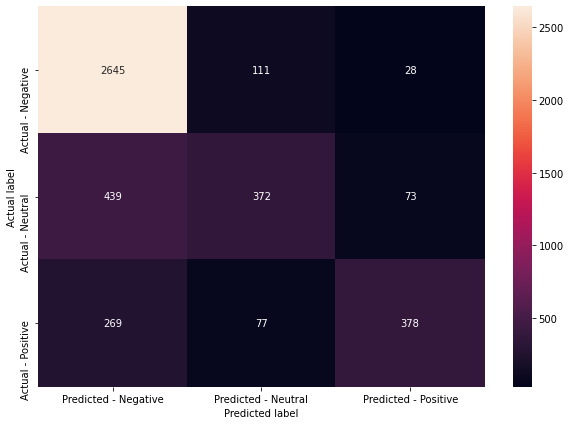

In [61]:
# Print and plot a Confusion matrix

conf_mat2 = confusion_matrix(y_test_tf, tf_test_result)

print(conf_mat2)
print()

df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in ["Actual - Negative", "Actual - Neutral", "Actual - Positive"]],
                  columns = [i for i in ["Predicted - Negative", "Predicted - Neutral", "Predicted - Positive"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm2, annot=True, fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Observations
- Similar to the CountVectorizer model, the TF-IDF model is suffering from the imbalanced data. It is over-predicting tweets as negative, especially confusing them with tweets that are actually neutral. 
- This model does a fairly good job when predicting a tweet is positive. 

## Top 40 Features with TF-IDF

In [62]:
# Show the top 40 features for TF-IDF & Random Forest Model

all_features2 = tfidf.get_feature_names()              #Instantiate the feature from the vectorizer
top_features2=''                                    # Addition of top 40 feature into top_feature after training the model
feat2=tf_rf_tuned.feature_importances_
features2=np.argsort(feat2)[::-1]
for i in features2[0:40]:
    top_features2+=all_features2[i]
    top_features2+=' '

print("The Top 40 features in this model are:")
top_features2

The Top 40 features in this model are:


'thank thanks not jetblue southwestair usairways united hour flight americanair great virginamerica delayed cancelled hold love customer get bag awesome service delay best hr need time call plane please much help good amazing still would airline worst dm got day '

#### Observations
- The top 40 features are a little different with TF-IDF.  This demosntrates that the way TF-IDF weighs words based on overall frequency of use resulted in a different set of top features. 
- "jetblue" is #4 instead of #5
- Interestingly the twitter handles for each airline are higher on this list than the CountVectorizer model. 

## Word Cloud with TF-IDF

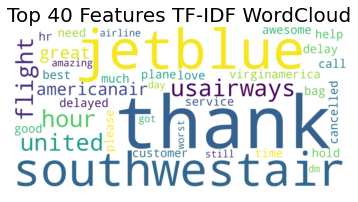

In [63]:
wordcloud_tf = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features2)

# Display the generated image:
plt.imshow(wordcloud_tf, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 Features TF-IDF WordCloud', fontsize=20)
plt.axis("off")
plt.show()

#### Observations
- Thank is again the prominent word in the word cloud
- jetblue also stands out as it did with CountVectorizer
- southwestair stands out with this TF-IDF model, whereas it was fairly small in the CountVectorizer word cloud. 

# 7. Conclusion

* This data set contained 14,640 tweets where customers @ mentioned one of 6 different U.S. airlines
* The data had a column where humans had classifed the tweets as positive, neutral, or negative
* The goal of the project was to do some pre-processing of the data and then create a model that could classify tweets as positive, negative, or neutral sentiment
* The data was imbalanced with many more negative labeled tweets than neutral or positive. I believe this created some overfitting later when I built the models. If I was going to work on this further, I would try oversampling and undersampling to see if I could improve performance.
* The data was also imbalanced as far as which airline the tweet was targeted at. United (the most common) had over 7 times more tweets directed at it than Virgin American (the lowest in this data set). I don't know that this had a significant effect, but I would definitely look into it to see if I could improve the model by addressing this issue.  
* Most of the other columns had very little or irrelevant data. The one exception is the column with a score for how confident the human was about the tweet sentiment. If I was continuing to work on this model I would look to incorporate that confidence level through feature engineering (maybe filtering out tweets with too low of a confidence level?) to see if I could improve the model by training with the tweets where the human was more confident. 
* I removed HTML tags during noise removal, which emliminated symbols like "&" 
* I removed URLs during noise removal -- there were many in the text because people often include links in tweets
* I also replace contractions, which are common in tweets, which increased the frequency of "not" in the text
* I removed numbers as they were not relevant to the task 
* I used tokenization to convert the text into a list of comma-separated words so I could do normalization functions to the tweets
* During normalization, I removed special characters (like emojis) and punctuation. If I was going to keep working on this, i would revisit some ways to convert the emojis to words because they add valuable context (smiley face vs a frown face), especially when the tweet is sarcastic and sounds positive but should be classified as negative. 
* I converted to lowercase, which is very important with tweets because people do not use proper capitalization
* I removed stopwords using a standard function. I chose to keep the word "not" because it is important for determining sentiment
* I used lemmatization rather than stemming in an effort to reduce dimensionality but maintain accuracy as much as possible. 
* After all that noise removal and normalization, I converted the tokenized text back into text strings so I could apply vectorization to it before fitting it to a model. 
* I used two forms of vectorization: CountVectorizer, which counts the frequency a word appears; and TF-IDF, which counts frequency but also adjusts it's importance by determining how often that word shows in the rest of the text (tweets in this case), giving frequent words less importance when fit in the model. 
* I chose to limit the number of words to the top 1,000 in an effort to avoid the curse of dimensionality. If I was doing more work on this model, I would test with other iterations of that word limit to see if more or fewer words results in better performance. 
* After I used CountVectorizer and TF-IDF, I had two new sets of data, which I fit to random forest classifiers to create two models. I tuned both models using RandomSearchCV to find the optimal hyperparameters. 


* It was surprsing to me that the CountVectorizer model actually performed better on test data than the TF-IDF. I expected TF-IDF to do better because of how it adjusts feature importance based on frequency. 
* Regardless, both models suffered from overfitting and need additional work. I would start with trying to address the imbalance in the data using oversampling and undersampling. I would also try more iterations doing things like adjusting the word limit in the vectorizer step, adding more stopwords to the list (such as each airlines twitter handle), using the sentiment confidence column to create additional labels (like confident negative and possibly negative), and using other classifiers. 